# COSC-523: Project 02: Face Detection Pipeline with Haar Cascade

**Matthew Vierheller**

[PLACEHOLDER_FOR_NOTEBOOK_LINK]


## Getting Started

Follow the instructions below to copy this notebook and to perform some initial setup.

1. Copy this notebook by selecting `File > Save a copy in Drive`.
2. A new window should open for the copied notebook. Move the new notebook to your course folder in Google Drive by selecting `File > Move` and then selecting the desired folder.
3. Update the name of the notebook by removing "Copy of" and replacing "Username" with your actual username.
4. Update the first cell in the notebook by specifying your course number (423 or 523) and by replacing "**Student Name**" with your actual name.
5. Do not edit the line that says `PLACEHOLDER_FOR_NOTEBOOK_LINK`. This will be used by the [Notebook Renderer](https://colab.research.google.com/drive/1CJTipys46ldZxJFwnt7XbdjQUfkmoXeU?usp=sharing) tool to insert a link to your Colab notebook.
6. Enable link sharing for your notebook.

## Task 1a: Morphological Vessel Operations

Look at the research paper provided on Canvas and go to Page 3. This paper is the extension of the research paper you saw in Project 1.
- Download the images, lesions and masks
- Go to page 3 of the paper, column 2 and you will find this description: "Due to the narrowness of the vessels, all the vessel
masks are dilated with a 3 × 3 structuring element and
closed with a 2 × 2 structuring element, as shown in Fig. 4.
This dilation prevents the vessels in the masks from being
broken when augmented. Since the goal is to identify vessels
within the lesion, the vessel masks are multiplied with
U-Net-generated lesion masks to yield vessels only within
the lesion. For both models, the images were square-cropped
and then resized to 448 × 448."
- Apply these steps to the 3 vessel masks and lesions provided and generate the final dilated, closed masks within the lesions.


In [ ]:
!apt-get install tesseract-ocr -y
!pip install pytesseract
!tesseract --version
! pip install Pillow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
tesseract 4.1.1
 leptonica-1.82.0
  libgif 5.1.9 : libjpeg 8d (libjpeg-turbo 2.1.1) : libpng 1.6.37 : libtiff 4.3.0 : zlib 1.2.11 : libwebp 1.2.2 : libopenjp2 2.4.0
 Found AVX2
 Found AVX
 Found FMA
 Found SSE
 Found libarchive 3.6.0 zlib/1.2.11 liblzma/5.2.5 bz2lib/1.0.8 liblz4/1.9.3 libzstd/1.4.8


In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import cv2

def dilate_closing(image):
  _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
  kernel_1 = np.ones((3,3), np.uint8)
  kernel_2 = np.ones((2,2), np.uint8)
  dilated_image = cv2.dilate(binary_image, kernel_1, iterations = 1)
  closed_dilated_image = cv2.morphologyEx(dilated_image, cv2.MORPH_CLOSE, kernel_2)
  return closed_dilated_image

def process_vessel_and_lesion(vessel_mask, lesion_mask):
  vessel_mask = cv2.cvtColor(vessel_mask, cv2.COLOR_BGR2GRAY)
  lesion_mask = cv2.cvtColor(lesion_mask, cv2.COLOR_BGR2GRAY)
  processed_vessel = dilate_closing(vessel_mask)

  _, binary_lesion = cv2.threshold(lesion_mask, 127, 255, cv2.THRESH_BINARY)
  vessels_within_lesion = cv2.bitwise_and(processed_vessel, binary_lesion)

  _, binary_vwl = cv2.threshold(vessels_within_lesion, 127, 255, cv2.THRESH_BINARY)

  h,w = binary_vwl.shape
  min_dim = min(h,w)
  x1 = (w-min_dim)//2
  y1 = (h-min_dim)//2

  cropped = vessels_within_lesion[y1:y1+min_dim, x1:x1+min_dim]
  resized_img = cv2.resize(cropped, (448,448), interpolation = cv2.INTER_NEAREST)

  return resized_img

In [ ]:
vessels1 = files.upload()
vessels1_path = next(iter(vessels1))
vessels2 = files.upload()
vessels2_path = next(iter(vessels2))
vessels3 = files.upload()
vessels3_path = next(iter(vessels3))

lesion1 = files.upload()
lesion1_path = next(iter(lesion1))
lesion2 = files.upload()
lesion2_path = next(iter(lesion2))
lesion3 = files.upload()
lesion3_path = next(iter(lesion3))

Saving br042208rol367_CNP.JPG to br042208rol367_CNP (2).JPG


Saving hp041808rol363_NCP.JPG to hp041808rol363_NCP (2).JPG


Saving rf071808rol439_CNP.jpg to rf071808rol439_CNP (3).jpg


Saving br042208rol367_CNP.JPG to br042208rol367_CNP (3).JPG


Saving hp041808rol363_NCP.JPG to hp041808rol363_NCP (3).JPG


Saving rf071808rol439_CNP.jpg to rf071808rol439_CNP (4).jpg


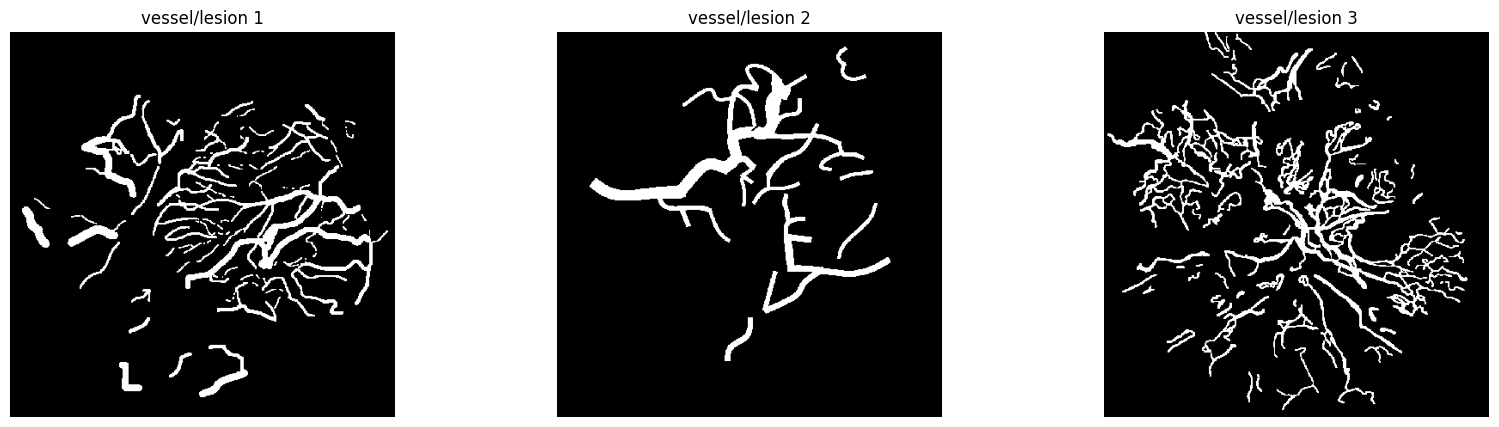

In [ ]:
vessel1 = cv2.imread(vessels1_path)
vessel2 = cv2.imread(vessels2_path)
vessel3 = cv2.imread(vessels3_path)

lesion1 = cv2.imread(lesion1_path)
lesion2 = cv2.imread(lesion2_path)
lesion3 = cv2.imread(lesion3_path)

vessels = [vessel1, vessel2, vessel3]
lesions = [lesion1, lesion2, lesion3]


img1 = process_vessel_and_lesion(vessel1, lesion1)
img2 = process_vessel_and_lesion(vessel2, lesion2)
img3 = process_vessel_and_lesion(vessel3, lesion3)

captions = ['vessel/lesion 1', 'vessel/lesion 2', 'vessel/lesion 3']
imgs = [img1, img2, img3]
plt.figure(figsize = (20,5))
for i in range(len(imgs)):
  plt.subplot(1,len(imgs), i+1)
  plt.imshow(imgs[i],cmap = 'gray')
  plt.title(captions[i])
  plt.axis('off')
plt.show()


## Task 1b: Finding largest vessles

- Choose the vessel file: rf071808rol439_CNP.jpg and apply all the operations you applied to it in Task 1a. While applying closing you might want to increase the kernel element structure size to see better closed vessels and not have too many broken vessels. The paper used a value of 2 because it had a different objective than what we are trying to achieve here.
- Now use the connected components methodoly to find the number of connected vessels. Call the function to display the labeled image. You will see a colorful image
- Our goal now is to create a binary image that only shows us the largest vessel. In this particular image, the largest (spanning the most pixels) connected vessels are the group on the top right, green in color (look at the connected vessels image provided for reference). We need to go from this to biggest_vessel.PNG, thats what we need to create. Here are some hints on how to do this:
 - The labels_im variable gives you the numpy array for the oringinal image with every pixel having the label of which component it belongs to. You can use np.unique to figure out how many unique labels there are (you can use a variation of np.unique to figure out pixel count for each label). For my code, I have 48 unique labels on the image. Also, as an example, the label 0 appears on 519172 pixels, which denotes the largest connected component in the image, the area without the vessels
 -  Now in order to find the largest vessel you have to find the 2nd largest group of pixels belonging to a label
 - Once you have found the 2nd largest pixel value belonging to a label, find that label and use np.where to create an image where only the pixels belonging to the largest vessels are white and rest everything is black, the final output image is given for reference. Dsiplay the final image

In [ ]:
vessel_image = files.upload()
vessel_img_path = next(iter(vessel_image))
vessel_image = cv2.imread(vessel_img_path)

Saving rf071808rol439_CNP.jpg to rf071808rol439_CNP (5).jpg


In [ ]:
gray_image = cv2.cvtColor(vessel_image, cv2.COLOR_BGR2GRAY)

In [ ]:

def dilate_closing(image, kernel_size_dilate=(3,3), kernel_size_close=(5,5)):
   _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
   kernel_dilate = np.ones(kernel_size_dilate, np.uint8)
   kernel_close = np.ones(kernel_size_close, np.uint8)
   dilated_image = cv2.dilate(binary_image, kernel_dilate, iterations=1)
   closed_dilated_image = cv2.morphologyEx(dilated_image, cv2.MORPH_CLOSE, kernel_close)
   return closed_dilated_image


def process_vessel_and_lesion(vessel, mask):
  #vessel_mask = cv2.cvtColor(vessel_mask, cv2.COLOR_BGR2GRAY)
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  processed_vessel = dilate_closing(vessel)

  _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
  vessel_with_mask = cv2.bitwise_and(processed_vessel, binary_mask)

  _, binary_img = cv2.threshold(vessel_with_mask, 127, 255, cv2.THRESH_BINARY)

  h,w = binary_img.shape
  min_dim = min(h,w)
  x1 = (w-min_dim)//2
  y1 = (h-min_dim)//2

  cropped = vessel_with_mask[y1:y1+min_dim, x1:x1+min_dim]
  resized_img = cv2.resize(cropped, (448,448), interpolation = cv2.INTER_NEAREST)

  return resized_img

gray_img = process_vessel_and_lesion(gray_image, vessel3)

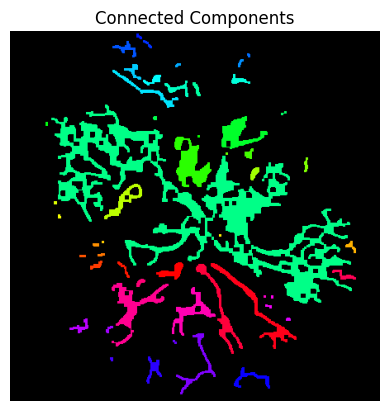

The number of Unique Components: 53


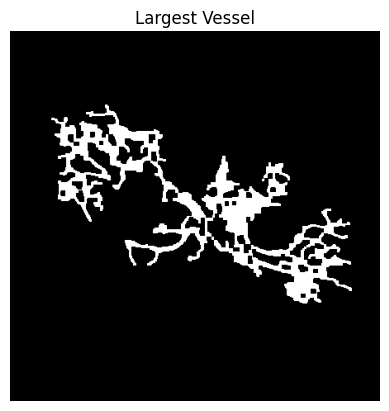

'largest_vessel'

In [ ]:
def imshow_components(labels):
   label_hue = np.uint8(179 * labels / np.max(labels))
   blank_ch = 255 * np.ones_like(label_hue)
   labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
   labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
   labeled_img[label_hue == 0] = 0

   plt.imshow(labeled_img)
   plt.axis('off')
   plt.title("Connected Components")
   plt.show()

def extract_largest_vessel(gray_image):
   processed = dilate_closing(gray_image)
   num_labels, labels_im = cv2.connectedComponents(processed)
   imshow_components(labels_im)
   unique, counts = np.unique(labels_im, return_counts=True)
   print(f'The number of Unique Components: {len(unique)}')
   sorted_counts = sorted(zip(unique, counts), key=lambda x: x[1], reverse=True)
   largest_vessel_label = sorted_counts[1][0]

   largest_vessel = np.where(labels_im == largest_vessel_label, 255, 0).astype(np.uint8)


   plt.imshow(largest_vessel, cmap='gray')
   plt.axis('off')
   plt.title("Largest Vessel")
   plt.show()

   return 'largest_vessel'

extract_largest_vessel(gray_img)

## Task 2a: LICENSE PLATE DETECTION USING HAAR CASCADES

During Week 4 we implemented Haar Cascades for face detection. In this project we will use Haar Cascades for License Plate Detection. Here are the important steps:
- Download the images Car1 and Car2 on Canvas
- The article link for Task 2 shows a complete implementation of Haar Cascades for License Plate Detection
- Go through this article thoroughly and use the code provided in it to read the license plates for Car1 and Car2
- The following is code you should include at the start of your notebook:

In [ ]:
car1_upload = files.upload()
car1_path = next(iter(car1_upload))

car2_upload = files.upload()
car2_path = next(iter(car2_upload))

Saving Car1.png to Car1 (3).png


Saving Car2.webp to Car2 (3).webp


In [ ]:
haarcascade = files.upload()
haarcascade_path = next(iter(haarcascade))
lic_data = cv2.CascadeClassifier(haarcascade_path)

Saving haarcascade_russian_plate_number.xml to haarcascade_russian_plate_number (4).xml


In [ ]:
def plt_show(image, title = '', gray = False, size = (100,100)):
  temp = image
  if gray == False:
    temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
    plt.title(title)
    plt.imshow(temp, cmap = 'gray')
    plt.show()

In [ ]:
def detect_number(img):
  temp = img
  gray = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
  number = lic_data.detectMultiScale(gray, 1.29)
  print("number plate detected:" + str(len(number)))
  for numbers in number:
    (x,y,w,h) = numbers
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    cv2.rectangle(temp, (x,y), (x+w, y+h), (0,255,0), 3)

    plt_show(temp)

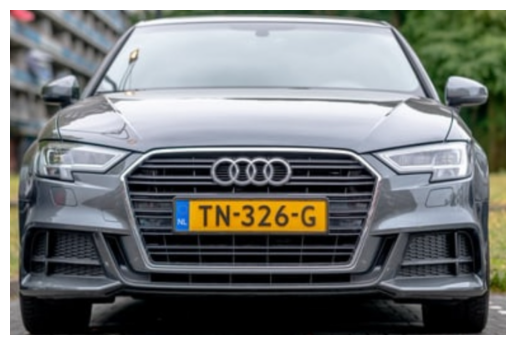

number plate detected:1


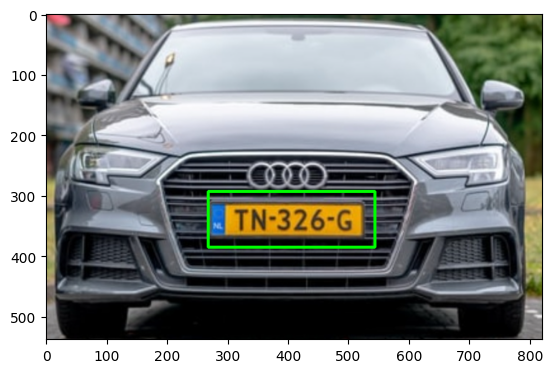

In [ ]:
img = cv2.imread(car1_path)
plt.axis('off')
plt_show(img)
detect_number(img)

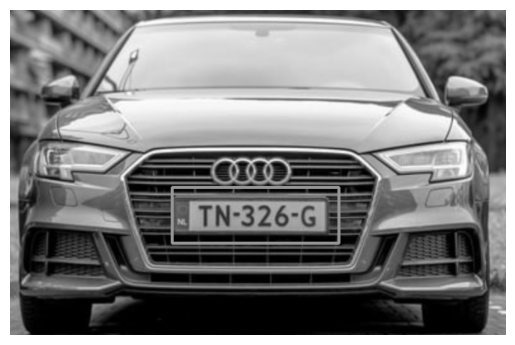

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.axis('off')
plt_show(gray)

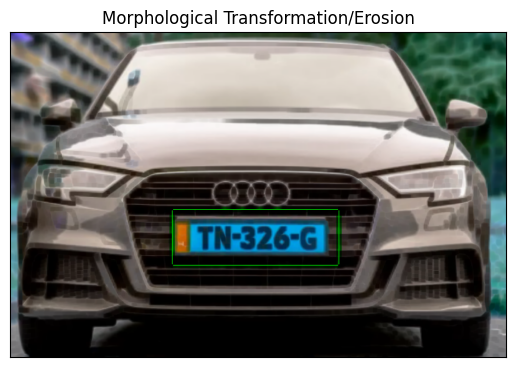

In [ ]:
kernel = np.ones((5,5), np.uint8)
erosion = cv2.erode(img, kernel, iterations = 1)

plt.imshow(erosion)
plt.title('Morphological Transformation/Erosion'), plt.xticks([]), plt.yticks([])
plt.show()

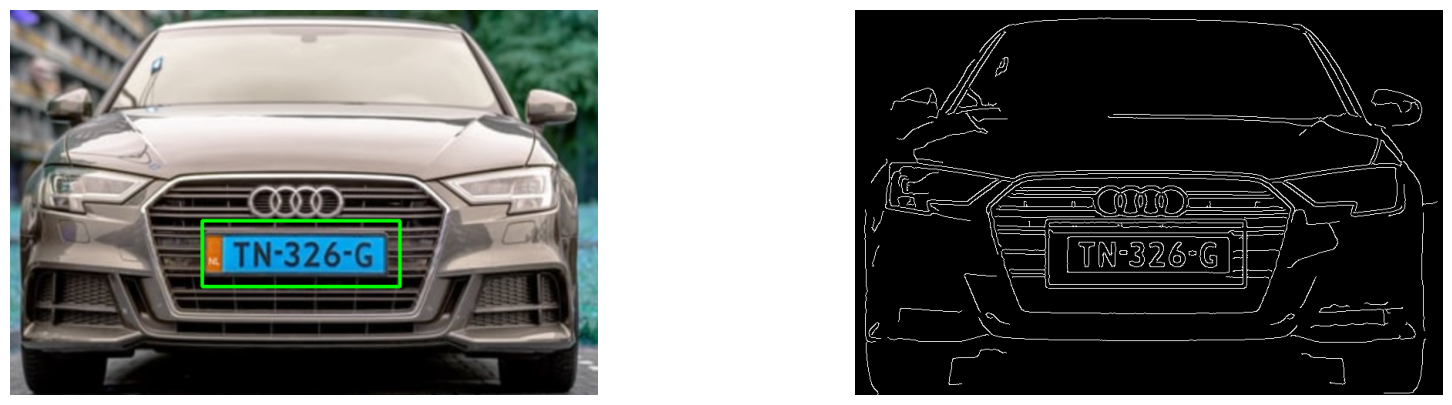

In [ ]:
import imutils
image = img
ratio = image.shape[0]/500.0
orig = image.copy()
image = imutils.resize(image, height = 500)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7,7), 0)
edged = cv2.Canny(gray, 75, 200)


plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(image, cmap = 'gray')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(edged, cmap = 'gray')
plt.show()

In [ ]:
contours = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
screenCnt = None

In [ ]:
for c in contours:  # contours is a list of detected contours, which are essentially the boundaries of detected objects. The loop iterates through each contour to find the one that looks like a rectangle (four-sided polygon).
    # approximate the contour
    peri = cv2.arcLength(c, True)  # computes the perimeter (arc length) of the contour c
    approx = cv2.approxPolyDP(c, 0.018 * peri, True) #The second argument (True) indicates that the contour is closed (a complete loop).Cv2.approxPolyDP() simplifies the contour to fewer points.

    # if our approximated contour has four points, then
    # we can assume that we have found our screen
    if len(approx) == 4: #The second argument (0.018 * peri) controls the approximation accuracy: A lower value keeps more detail.The third argument (True) ensures the approximated contour remains closed.
                            # If the approximated contour has exactly 4 points, it is assumed to be a quadrilateral (rectangle/square).
        screenCnt = approx
        break

In [ ]:
if screenCnt is None:
  detected = 0
  print('No contour detected')

else:
   detected = 1

if detected == 1:
  cv2.drawContours(img, [screenCnt], -1, (0,0,255),3)

In [ ]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [screenCnt], 0, 255, -1,)
new_image = cv2.bitwise_and(image,image, mask = mask)


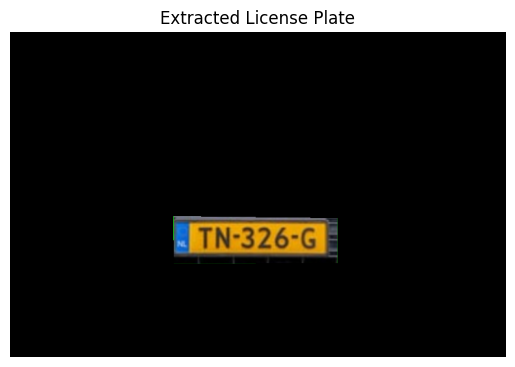

In [ ]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for matplotlib
plt.axis('off')
plt.title('Extracted License Plate')
plt.show()

In [ ]:
(x,y) = np.where(mask == 255)
(topx, topy) = (np.min(x), np.min(y))
(bottomx, bottomy) = (np.max(x), np.max(y))
cropped = gray[topx:bottomx+1, topy:bottomy+1]

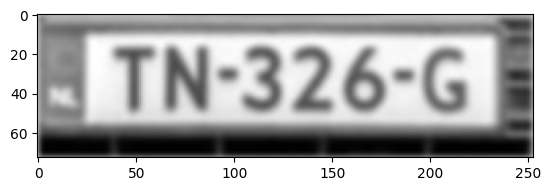

In [ ]:
plt.imshow(cropped, cmap = 'gray')


In [ ]:
import pytesseract
text = pytesseract.image_to_string(cropped, config = '--psm 10')
print(f'Detected license plate Number is: {text}')

Detected license plate Number is: § TN-326-G



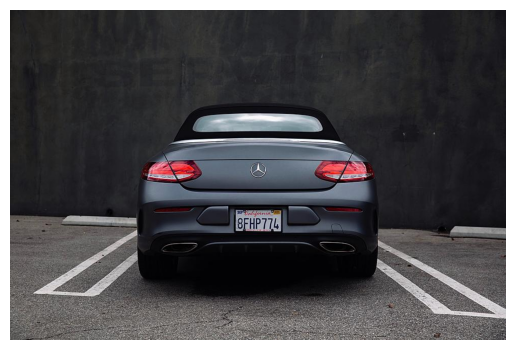

number plate detected:0


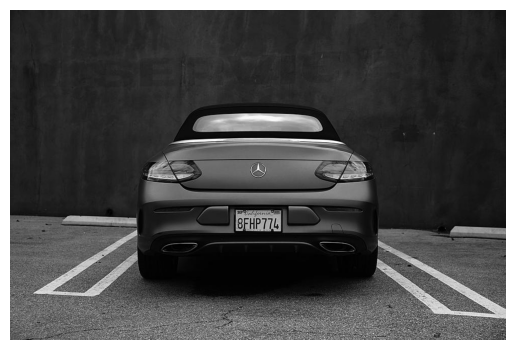

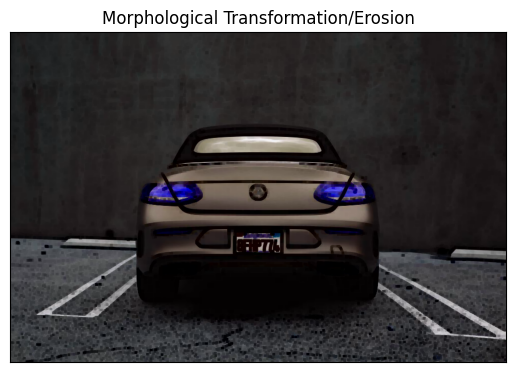

In [ ]:
img = cv2.imread(car2_path)
plt.axis('off')
plt_show(img)
detect_number(img)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.axis('off')
plt_show(gray)

kernel = np.ones((5,5), np.uint8)
erosion = cv2.erode(img, kernel, iterations = 1)

plt.imshow(erosion)
plt.title('Morphological Transformation/Erosion'), plt.xticks([]), plt.yticks([])
plt.show()

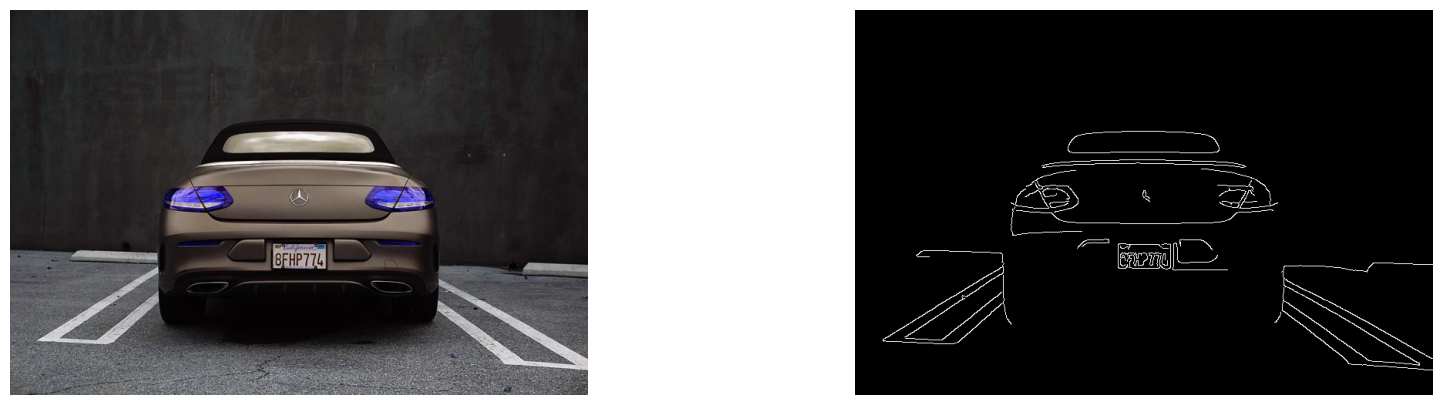

In [ ]:
import imutils
image = img
ratio = image.shape[0]/500.0
orig = image.copy()
image = imutils.resize(image, height = 500)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7,7), 0)
edged = cv2.Canny(gray, 75, 200)


plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(image, cmap = 'gray')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(edged, cmap = 'gray')
plt.show()

In [ ]:
contours = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
screenCnt = None

In [ ]:
for c in contours:  # contours is a list of detected contours, which are essentially the boundaries of detected objects. The loop iterates through each contour to find the one that looks like a rectangle (four-sided polygon).
    # approximate the contour
    peri = cv2.arcLength(c, True)  # computes the perimeter (arc length) of the contour c
    approx = cv2.approxPolyDP(c, 0.018 * peri, True) #The second argument (True) indicates that the contour is closed (a complete loop).Cv2.approxPolyDP() simplifies the contour to fewer points.

    # if our approximated contour has four points, then
    # we can assume that we have found our screen
    if len(approx) == 4: #The second argument (0.018 * peri) controls the approximation accuracy: A lower value keeps more detail.The third argument (True) ensures the approximated contour remains closed.
                            # If the approximated contour has exactly 4 points, it is assumed to be a quadrilateral (rectangle/square).
        screenCnt = approx
        break

In [ ]:
if screenCnt is None:
  detected = 0
  print('No contour detected')

else:
   detected = 1

#if detected == 1:
#  cv2.drawContours(img, [screenCnt], -1, (0,0,255),3)



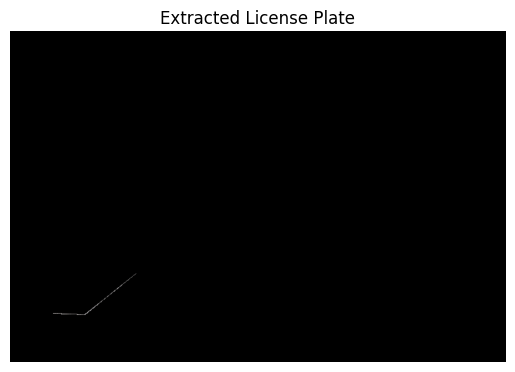

In [ ]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [screenCnt], 0, 255, -1,)
new_image = cv2.bitwise_and(image,image, mask = mask)

plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for matplotlib
plt.axis('off')
plt.title('Extracted License Plate')
plt.show()

In [ ]:
(x,y) = np.where(mask == 255)
(topx, topy) = (np.min(x), np.min(y))
(bottomx, bottomy) = (np.max(x), np.max(y))
cropped = gray[topx:bottomx+1, topy:bottomy+1]

Detected license plate Number is: Af



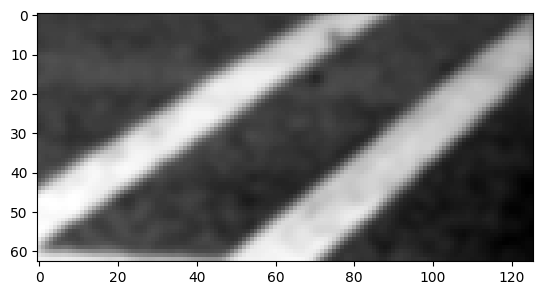

In [ ]:
plt.imshow(cropped, cmap = 'gray')
import pytesseract
text = pytesseract.image_to_string(cropped, config = '--psm 10')
print(f'Detected license plate Number is: {text}')

-  At the very end, you might still see a small error like "NameError: name 'pytesseract' is not defined", you should be able to fix this quickly.

## Task 2b: LICENSE PLATE DETECTION USING HAAR CASCADES: Analysis
- The code should work properly on Car1 but fails to work on Car2. Can you explain why?<br>
Hint: This chunk of code below can provide us with the answers. Read the comments I have provided to think and explain what might be happening with Car2's implementation not working properly

In [ ]:
for c in contours:  # contours is a list of detected contours, which are essentially the boundaries of detected objects. The loop iterates through each contour to find the one that looks like a rectangle (four-sided polygon).
    # approximate the contour
    peri = cv2.arcLength(c, True)  # computes the perimeter (arc length) of the contour c
    approx = cv2.approxPolyDP(c, 0.018 * peri, True) #The second argument (True) indicates that the contour is closed (a complete loop).Cv2.approxPolyDP() simplifies the contour to fewer points.

    # if our approximated contour has four points, then
    # we can assume that we have found our screen
    if len(approx) == 4: #The second argument (0.018 * peri) controls the approximation accuracy: A lower value keeps more detail.The third argument (True) ensures the approximated contour remains closed.
                            # If the approximated contour has exactly 4 points, it is assumed to be a quadrilateral (rectangle/square).
        screenCnt = approx
        break

Task 2b: Answer here
With the little bumps on the license plate that forms the outside of the plate with numbers/letters inside, the algorithm finds more than 4 sides so it cannot detect the full plate properly for the other operations.

# Submission Instructions

1. Perform a Restart and Run All by clicking **Tools > Restart session and run all**.
2. Copy the link to your notebook by clicking **Share > Copy Link**.
3. Paste the copied link into the `notebook_url` field in the [Notebook Renderer](https://colab.research.google.com/drive/1CJTipys46ldZxJFwnt7XbdjQUfkmoXeU?usp=sharing) tool and then execute the cell to render the notebook.
4. The Notebook Renderer will open up a save file dialog. Save the resulting HTML file yo your local machine.
5. Submit the HTML file to Canvas.
